<a href="https://colab.research.google.com/github/advoet/fremont-bikes/blob/main/fremont_bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO-DO**:
 - Daylight Savings
 - Weather
 - Lag features (days, full week, full year)

# Fremont Bicycle Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
%matplotlib inline

## Load the data

In [3]:
import os.path as path
from google.colab import files

if not path.exists('Fremont_Bridge_Bicycle_Counter.csv'):
  uploaded = files.upload()

all_data = pd.read_csv("Fremont_Bridge_Bicycle_Counter.csv")

Saving Fremont_Bridge_Bicycle_Counter.csv to Fremont_Bridge_Bicycle_Counter.csv


In [4]:
date_time = pd.to_datetime(all_data["Date"])
datetime_index = pd.DatetimeIndex(date_time.values)
all_data.set_index(datetime_index, inplace = True)
all_data.drop(columns = ["Date"], inplace = True)
# drops daylight savings hours 
all_data = all_data[~all_data.index.duplicated()]
all_data.columns = ['total', 'east', 'west']

In [5]:
all_data.head()

,total,east,west
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [6]:
all_data = all_data.asfreq('h')

## Data Exploration

First, let's deal with some nans

In [7]:
# Daylight savings & ?
all_data[all_data["total"].isna()]

,total,east,west
2013-06-14 09:00:00,NaN,NaN,NaN
2013-06-14 10:00:00,NaN,NaN,NaN
2014-03-09 02:00:00,NaN,NaN,NaN
2015-03-08 02:00:00,NaN,NaN,NaN
2015-04-21 11:00:00,NaN,NaN,NaN
2015-04-21 12:00:00,NaN,NaN,NaN
2016-03-13 02:00:00,NaN,NaN,NaN
2017-03-12 02:00:00,NaN,NaN,NaN
2018-03-11 02:00:00,NaN,NaN,NaN
2019-03-10 02:00:00,NaN,NaN,NaN


In [8]:
# TO-DO: Better imputation -- train test split FIRST, then calculate means
all_data.fillna(0, inplace=True)

### Plot the Data

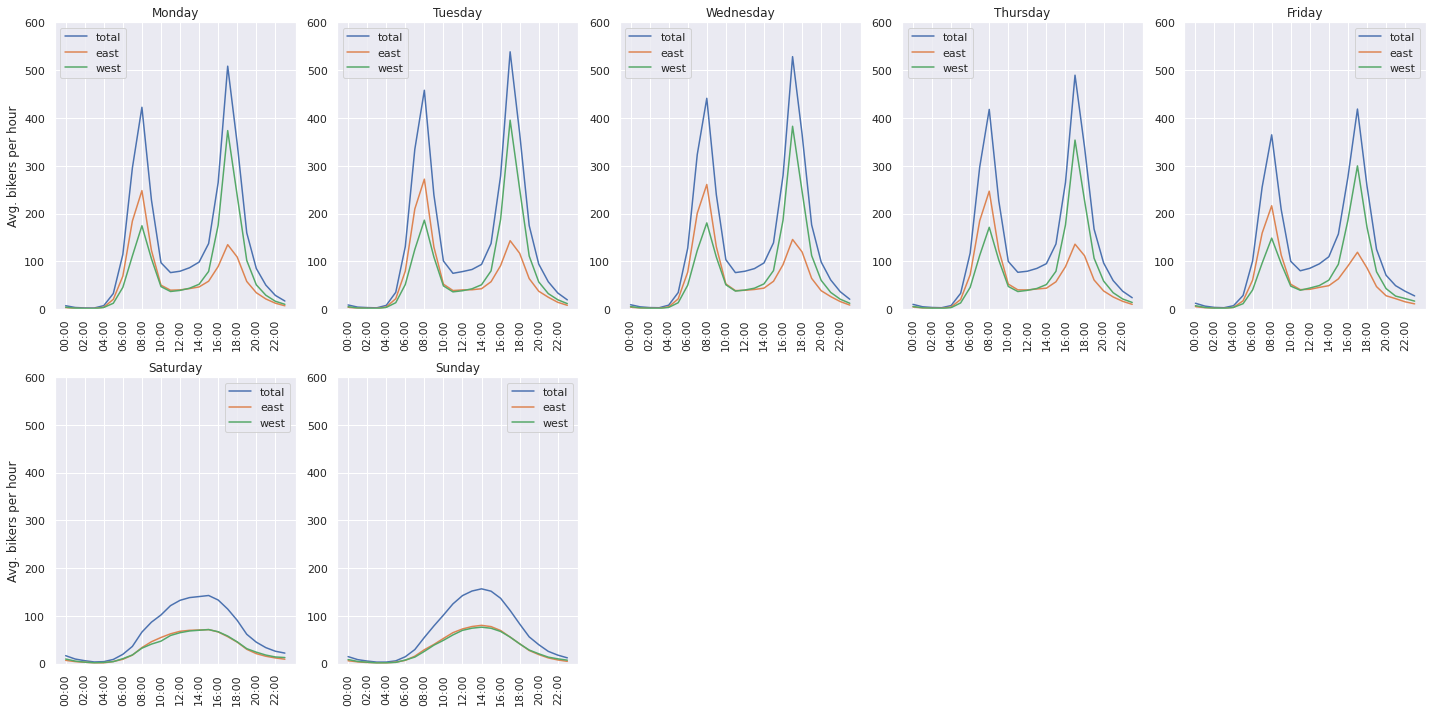

In [11]:
day_groups = all_data[['total','east','west']].groupby(
    all_data.index.dayofweek
)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for a in [axes[1,2], axes[1,3], axes[1,4]]:
  fig.delaxes(a)

axes = axes.flatten()

for idx, grp in day_groups:
  daily_avg = grp.groupby(grp.index.time).mean()
  
  # Standard line plot
  daily_avg.plot(
      ax = axes[idx],
      x_compat = True,
  )
  '''
  # Box/whisker plot
  # TO-DO: one for each season
  sns.boxplot(x=grp.index.hour, y=grp.total, ax = axes[idx])
  axes[idx].tick_params(
      axis = 'x',
      rotation = 90,
      )
  '''
  axes[idx].set_title(grp.index.day_name()[0])

import matplotlib as mpl
for ax in axes:
  ax.set_ylim((0,600))
  ax.tick_params(
      axis = 'both',
  )
  ax.tick_params(
      axis = 'x',
      rotation = 90,
  )
  locator = mpl.ticker.IndexLocator(base=2 * 60 * 60, offset=0)
  ax.xaxis.set_major_locator(locator)
  if ax in (axes[0], axes[5]):
    ax.set_ylabel("Avg. bikers per hour")
  ax.set_xlabel("")

plt.tight_layout()

In [12]:
daily_totals = all_data[['total', 'east', 'west']].resample('d').sum()
weekly_totals = all_data[['total', 'east', 'west']].resample('w').sum()
weekly_average = daily_totals.resample('w').mean()
monthly_average = weekly_average.resample('m').mean()
yearly_average = monthly_average.resample('y').mean()

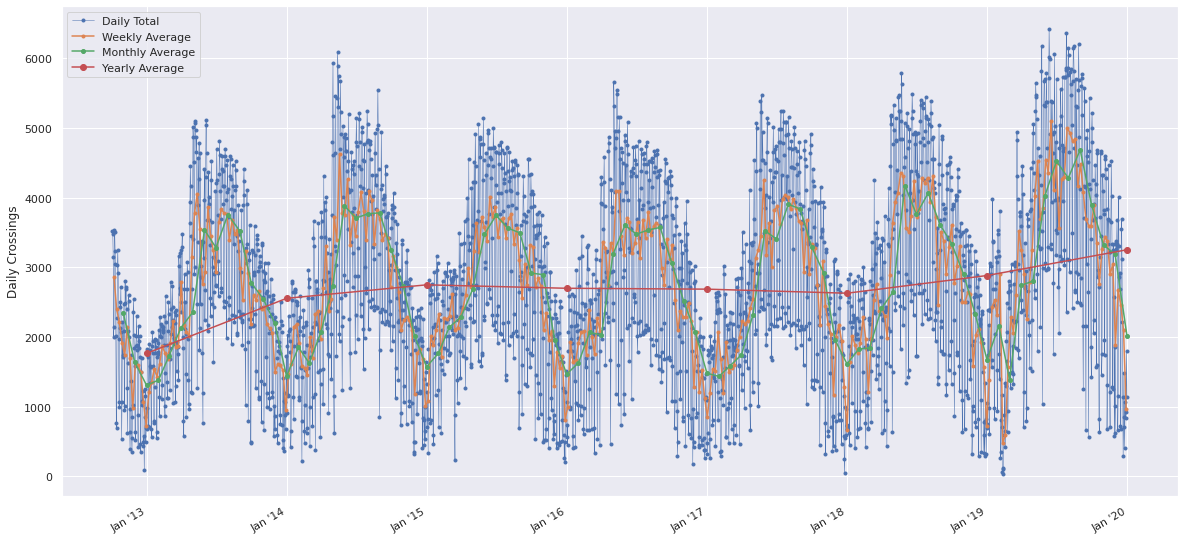

In [14]:

START, END = "2010", "2019"
TO_PLOT = ('d', 'w', 'm', 'y')

fig, ax = plt.subplots(figsize = (20,10))

if 'd' in TO_PLOT:
  ax.plot(
      daily_totals.loc[START:END]["total"],
      marker='.', linestyle='-', linewidth=0.5,
      label='Daily Total',
  )
if 'w' in TO_PLOT:
  ax.plot(
      weekly_average.loc[START:END]["total"],
      marker='o', markersize=3, linestyle='-',
      label='Weekly Average'
  )
if 'm' in TO_PLOT:
  ax.plot(
      monthly_average.loc[START:END]["total"],
      marker='o', markersize = 4, linestyle = '-',
      label = "Monthly Average",
  )
if 'y' in TO_PLOT:
  ax.plot(
      yearly_average.loc[START:END]["total"],
      marker='o', markersize = 6, linestyle = '-',
      label = "Yearly Average",
  )

ax.legend()
ax.tick_params(axis = 'both')
ax.set_ylabel("Daily Crossings")

from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
pass

### Investigating seasonality

TO - DO:
 - separate plots for weekday / weekend?
 - COVID, commuting was on up trend but sharp decline in 2020

In [15]:
daily_totals[daily_totals.index.dayofweek < 5]

,total,east,west
2012-10-03,3521.0,1760.0,1761.0
2012-10-04,3475.0,1708.0,1767.0
2012-10-05,3148.0,1558.0,1590.0
2012-10-08,3537.0,1829.0,1708.0
2012-10-09,3501.0,1759.0,1742.0
...,...,...,...
2020-08-25,3097.0,1276.0,1821.0
2020-08-26,3018.0,1282.0,1736.0
2020-08-27,3031.0,1307.0,1724.0
2020-08-28,2949.0,1183.0,1766.0


In [16]:
daily_totals['rolling_7'] = daily_totals['total'].rolling(7).mean()
daily_totals['rolling_30'] = daily_totals['total'].rolling(30).mean()
daily_totals['rolling_365'] = daily_totals['total'].rolling(365).mean()

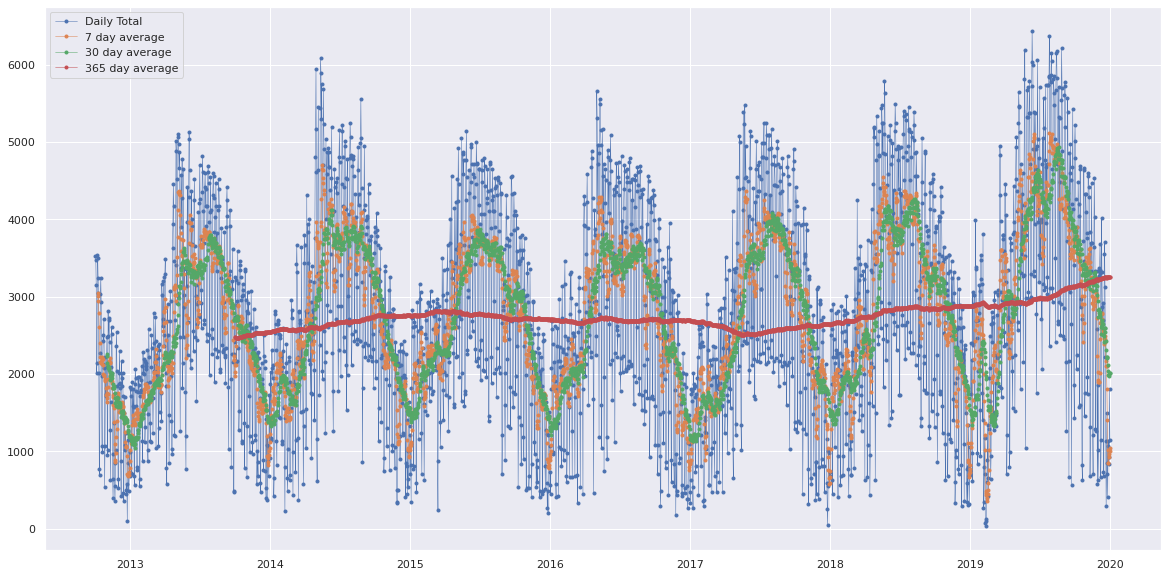

In [17]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(
      daily_totals.loc[START:END]["total"],
      marker='.', linestyle='-', linewidth=0.5,
      label='Daily Total',
)

ax.plot(
      daily_totals.loc[START:END]["rolling_7"],
      marker='.', linestyle='-', linewidth=0.5,
      label='7 day average',
)

ax.plot(
      daily_totals.loc[START:END]["rolling_30"],
      marker='.', linestyle='-', linewidth=0.5,
      label='30 day average',
)

ax.plot(
      daily_totals.loc[START:END]["rolling_365"],
      marker='.', linestyle='-', linewidth=0.5,
      label='365 day average',
)

plt.legend()
pass

In [18]:
weekday_totals = daily_totals[[daily_totals.index.dayofweek < 5]]
weekend_totals = daily_totals[[daily_totals.index.dayofweek >= 5]]

ValueError: ignored

In [19]:
def plot_seasonal(decomp, axes):
    decomp.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    decomp.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    decomp.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    decomp.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


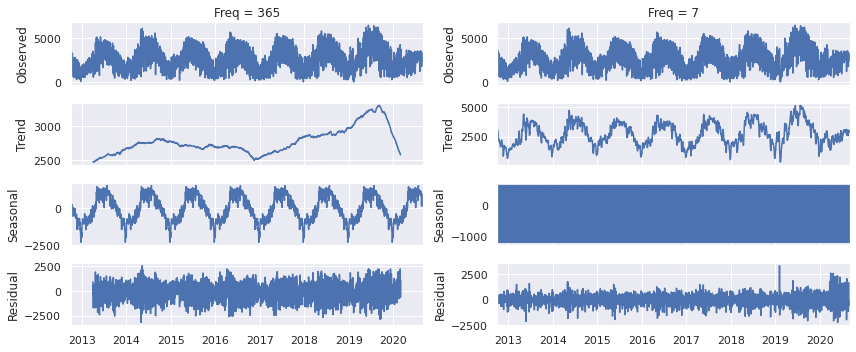

ADF Statistic: -3.413
n_lags:  0.011
p-value:  0.011
Critial Values:
   1%, -3.433
Critial Values:
   5%, -2.863
Critial Values:
   10%, -2.567


In [20]:
import statsmodels.api as sm
# freq 7 or 365?
# Maybe stabilize the yearly level then stabilize the weekly
yearly_decomp = sm.tsa.seasonal_decompose(daily_totals['total'], freq = 365, model = 'add')
weekly_decomp = sm.tsa.seasonal_decompose(daily_totals['total'], freq = 7, model = 'add')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plot_seasonal(yearly_decomp, axes[:,0])
plot_seasonal(weekly_decomp, axes[:,1])

for ax in axes.flatten():
  ax.tick_params(axis = 'both', )
  ax.set_ylabel(ax.get_ylabel(), )

axes[0,0].set_title('Freq = 365', )
axes[0,1].set_title('Freq = 7',)

plt.tight_layout()
plt.show()

result = sm.tsa.stattools.adfuller(daily_totals['total'], autolag = 'AIC')
print(f'ADF Statistic: {result[0] : .3f}')
print(f'n_lags: {result[1] : .3f}')
print(f'p-value: {result[1] : .3f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value : .3f}')   

## Let's predict

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

all_data["year"] = all_data.index.year
all_data["month"] = all_data.index.month
all_data["day_of_week"] = all_data.index.dayofweek
all_data["hour"] = all_data.index.hour
all_data["day_of_year"] = all_data.index.dayofyear
# Improve model with seasonal components
all_data["sin_hour"] = np.sin(all_data.hour*2*np.pi/24)
all_data["cos_hour"] = np.cos(all_data.hour*2*np.pi/24)
all_data["sin_day"] = np.sin(all_data.day_of_year*2*np.pi/365)
all_data["cos_day"] = np.cos(all_data.day_of_year*2*np.pi/365)
# Lag data
all_data["day-1"] = all_data['total'].shift(24, freq = 'h').fillna(0)
all_data["week-1"] = all_data['total'].shift(24*7, freq = 'h').fillna(all_data['total'])
for i in range(1,13):
  all_data[f"hour-{i}"] = all_data['total'].shift(i, freq = 'h').fillna(all_data['total'])


In [22]:
# SETUP  
features = [
            "year",
            "month",
            "sin_hour",
            "cos_hour",
            "sin_day",
            "cos_day",
            "day_of_week",
            "hour",
            ]
X = all_data[features]
y = all_data["total"]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=52)

In [23]:
# lag didn't do much
data_with_lag = all_data.iloc[24*7:]
lag_train_X, lag_val_X, lag_train_y, lag_val_y = train_test_split(X, y, random_state=52)

### Decision Tree

In [24]:
dt_model = DecisionTreeRegressor()

dt_model.fit(train_X, train_y)
val_pred = dt_model.predict(val_X)
mean_absolute_error(val_pred, val_y)

27.006113033448674

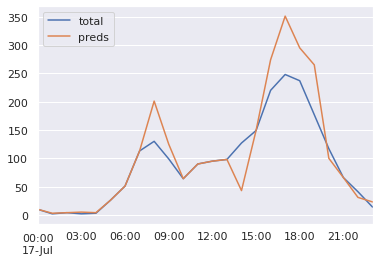

In [25]:
preds = dt_model.predict(X.loc['2020-07-17'])
actual = y.loc['2020-07-17'].to_frame()
actual['preds'] = preds
actual.plot()

### Random Forest

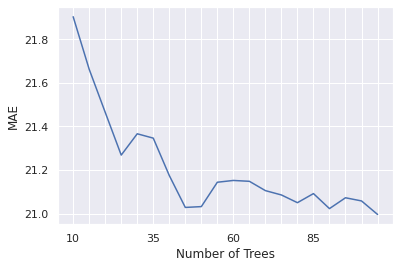

In [26]:

# TRAIN RANDOM FOREST REGRESSORS

val_mae = []
tree_num_list = [10 + 5*n for n in range(20)]
for num_trees in tree_num_list:
  rf_model = RandomForestRegressor(num_trees)
  rf_model.fit(train_X, train_y)

  val_predictions = rf_model.predict(val_X)
  val_mae.append(mean_absolute_error(val_predictions, val_y))

fig, ax = plt.subplots()
plt.plot(tree_num_list, val_mae)
ax.set_xlabel("Number of Trees", )
ax.set_ylabel("MAE", )
ax.set_xticks(tree_num_list)
ax.set_xticklabels(tree_num_list, )
ax.tick_params(axis = 'y',)
n = 5  # Keeps every 5th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
pass

In [ ]:
numtrees = 105
rf_model = RandomForestRegressor(n_estimators = 500)
rf_model.fit(lag_train_X, lag_train_y)

val_predictions = rf_model.predict(lag_val_X)
print(f'mae: {mean_absolute_error(val_predictions, lag_val_y)}')

mae: 20.95500507497117


What if we add some more features?
 - weather

### XGBoost

In [ ]:
import xgboost as xgb
xg_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=5000)
xg_model.fit(train_X, train_y,
        eval_set=[(train_X, train_y)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
val_pred = xg_model.predict(val_X)
mean_absolute_error(val_pred, val_y)

24.95721307326078

### ARIMA (incomplete)

In [30]:
daily_series = daily_totals['total']
daily_series.head()

2012-10-03    3521.0
2012-10-04    3475.0
2012-10-05    3148.0
2012-10-06    2006.0
2012-10-07    2142.0
Freq: D, Name: total, dtype: float64

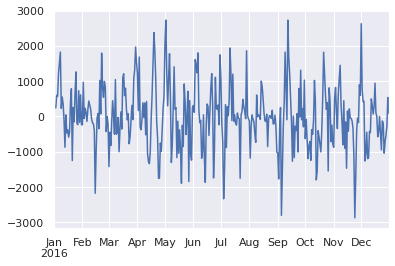

In [49]:
daily_stabilized = daily_series.diff(periods = 7)[7:]
daily_stabilized['2016'].plot()

In [59]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(daily_stabilized['2015':'2018'], order = (7, 0, 7))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                  total   No. Observations:                 1461
Model:                     ARMA(7, 7)   Log Likelihood              -11365.974
Method:                       css-mle   S.D. of innovations            574.630
Date:                Thu, 21 Jan 2021   AIC                          22763.947
Time:                        21:43:04   BIC                          22848.537
Sample:                    01-01-2015   HQIC                         22795.502
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1345     19.528     -0.058      0.954     -39.409      37.140
ar.L1.total     0.3938      0.041      9.526      0.000       0.313       0.475
ar.L2.total     0.0024      0.033      0.073    

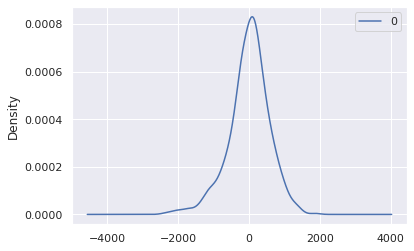

In [64]:
pd.DataFrame(model_fit.resid).plot(kind='kde')

In [70]:

from sklearn.metrics import mean_squared_error
from math import sqrt

series = daily_stabilized['2015']
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(7,0,7))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarni

KeyboardInterrupt: ignored

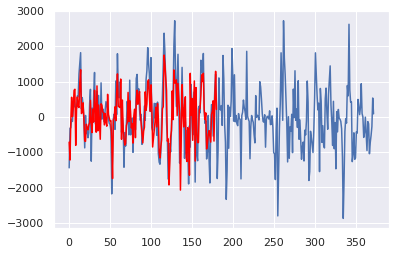

In [71]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### LSTM (incomplete)

In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

from google.colab import drive
# drive.mount('/gdrive')
# !ls /gdrive

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import math
import pt_util

ModuleNotFoundError: ignored

In [ ]:
train_df = hourly_data["Total"][:int(.8*len(hourly_data))]
test_df = hourly_data["Total"][int(.8*len(hourly_data)):]

In [ ]:
class BikeDataSet(Dataset):
  
  def __init__(self, csv_file, root_dir, seq_len, batch_size):
    # Data is cleaned first then saved to csv_file
    self.bike_df = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.seq_len = seq_len
    self.batch_size = batch_size
  
  def __len__(self):
    return len(self.bike_df)
  
  def __getitem__(self, idx):
    raise NotImplementedError


## Anomaly Detection (TO - DO)

In [ ]:
train = daily_totals.loc[:'2018']
test = daily_totals.loc['2018':]

In [ ]:
train.head()

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [ ]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train.total) ,seasonal_periods=365, trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [ ]:
import math
import sklearn.metrics as metrics
rms = math.sqrt(metrics.mean_absolute_error(test.total, y_hat_avg.Holt_Winter))
print(rms)